# Plotting wind barbs over interpolated dew points.

In [1]:
import io
import cartopy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import BoundaryNorm

from metpy.cbook import get_test_data
from metpy.calc import get_wind_components
from metpy.units import units
from metpy.plots import StationPlot
from metpy.mapping.map_functions import interpolate, remove_nans_and_repeats, threshold_value

Read in the data from 22 June 2016 and focus in on the upper midwest.

In [2]:
df = pd.read_csv(get_test_data("622161836_data.csv"))

df = df[(df['latitude'] >= 35) & 
        (df['latitude'] <= 50) & 
        (df['longitude'] > -100) & 
        (df['longitude'] < -80)]

We only want wind directions between 0 and 360.

In [3]:
df = df[(df['windSpeed'] >= 0) & 
        (df['windDir'] >= 0) & 
        (df['windDir'] <= 360) & 
        (df['dewpoint'] > -50)]

Extract the information we need to make the plot.

Convert dewpoint from celsius to fahrenheit.

In [4]:
x = np.array(df['longitude'])
y = np.array(df['latitude'])

td = np.array(df['dewpoint']) * 1.8 + 32
wspd = np.array(df['windSpeed'])
wdir = np.array(df['windDir'])

Project the lat/lon coordinates to Albers equal area.

In [5]:
from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

proj = to_proj.transform_points(from_proj, x, y)
x = proj[:, 0]
y = proj[:, 1]

Interpolate the dewpoint values to a grid.

In [6]:
gx, gy, td_int = interpolate(x, y, td, interp_type="linear", hres=2000)

Interpolate wind speed and direction by decomposing into u and v components.

We eventually want interpolated u and v information for each grid point to pass into StationPlot.

In [7]:
u, v = get_wind_components((wspd * units('m/s')).to('knots'),
                            wdir * units.degree)
windgridx, windgridy, uwind = interpolate(x, y, u, interp_type="linear", hres=25000)
_, _, vwind = interpolate(x, y, v, interp_type="linear", hres=25000)

Plot both the dewpoint colormesh and interpolated wind barbs using cartopy and metpy.

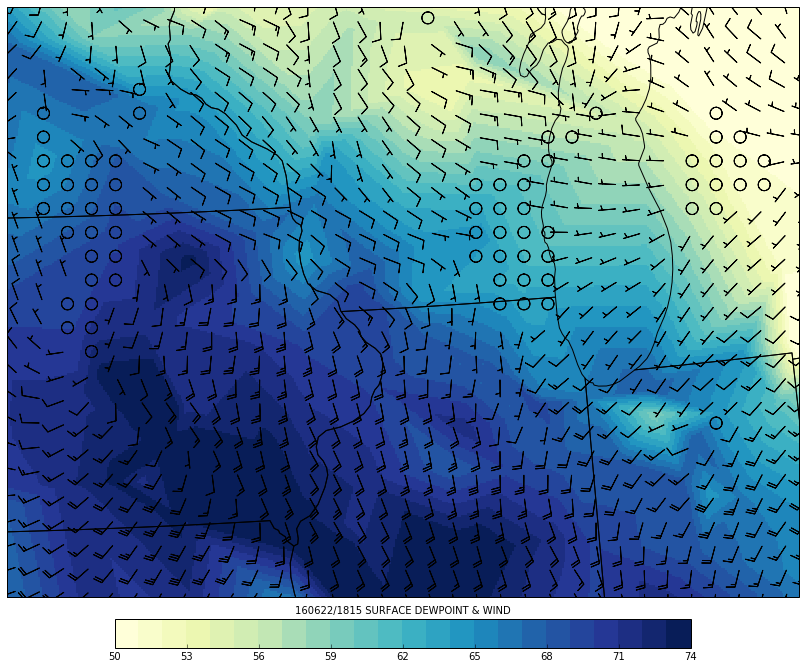

In [8]:
#Generate steps for the pcolormesh (eg, 50F to 75F, every degree F)
levels = list(range(50, 75, 1))
cmap = plt.get_cmap('YlGnBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

fig = plt.figure(figsize=(20, 10))
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-95, -85, 40, 45])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

mmb = view.pcolormesh(gx, gy, td_int, cmap=cmap, norm=norm)

stationplot = StationPlot(view, windgridx, windgridy, fontsize=9)

stationplot.plot_barb(uwind, vwind)

cb = plt.colorbar(mmb, shrink=.4, pad=0.03, orientation='horizontal', boundaries=levels, 
                   label="160622/1815 SURFACE DEWPOINT & WIND")

cb.ax.xaxis.set_label_position('top')